In [1]:
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader

from apn import APN
from data.cub.cub_dataset import CUBDataset

# Load Dataset and `APN` Model

In [3]:
test_transforms = T.Compose([
    T.Resize(size=448),
    T.CenterCrop(size=448),
    T.ToTensor()
])

dataset_val = CUBDataset(os.path.join('datasets', 'CUB'), num_attrs=107, split='val', transforms=test_transforms)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=4, shuffle=True, num_workers=8)
dataloader_val_iter = iter(dataloader_val)

In [5]:
backbone_weights = torch.load('checkpoints/resnet101_ft_CUB.pt', map_location='cpu')
apn_net = APN(num_classes=200,
              num_attrs=107,
              class_attr_embs=dataset_val.class_attr_embs,
              backbone_name='resnet101',
              backbone_weights=backbone_weights,
              dist='dot')
full_weghts = torch.load('checkpoints/apn_CUB.pt', map_location='cpu')
apn_net.load_state_dict(full_weghts)

<All keys matched successfully>

In [6]:
apn_net.eval()
with torch.no_grad():
    batch_dict = next(dataloader_val_iter)
    outputs = apn_net(batch_dict)

In [7]:
list(outputs.keys())

['class_scores', 'attr_scores', 'attn_maps']

In [26]:
dataset_val.attribute_df.reset_index(drop=True).iloc[[45,26,92,60,103]]

,attribute_name,part_name,part_id
45,has_throat_color::grey,breast,3
26,has_back_color::grey,back,1
92,has_leg_color::black,leg,4
60,has_under_tail_color::grey,tail,5
103,has_wing_pattern::solid,wing,6


In [34]:
dataset_val.attribute_df.reset_index(drop=True).iloc[[50, 11, 26, 22, 86, 17, 84, 71, 40, 51]]

,attribute_name,part_name,part_id
50,has_eye_color::black,head,0
11,has_upperparts_color::grey,breast,3
26,has_back_color::grey,back,1
22,has_breast_pattern::solid,breast,3
86,has_primary_color::grey,breast,3
17,has_underparts_color::grey,belly,2
84,has_belly_pattern::solid,belly,2
71,has_belly_color::grey,belly,2
40,has_breast_color::grey,breast,3
51,has_bill_length::about_the_same_as_head,head,0


In [38]:
with open('attrs.txt', 'w') as fp:
    dataset_val.attribute_df.to_string(fp)

In [33]:
torch.topk(batch_dict['attr_scores'][0], 10)

torch.return_types.topk(
values=tensor([0.9796, 0.9054, 0.8872, 0.8766, 0.8727, 0.8710, 0.8662, 0.8662, 0.7937,
        0.7838]),
indices=tensor([50, 11, 26, 22, 86, 17, 84, 71, 40, 51]))

In [22]:
torch.topk(dataset_val.class_attr_embs[60], 5)

torch.return_types.topk(
values=tensor([0.9796, 0.9054, 0.8872, 0.8766, 0.8727]),
indices=tensor([50, 11, 26, 22, 86]))

In [32]:
dataset_val.main_df.iloc[3495]

file_path    061.Heermann_Gull/Heermann_Gull_0087_45658.jpg
class_id                                                 60
is_train                                                  0
Name: 3495, dtype: object

In [30]:
batch_dict['image_ids']

tensor([ 3495, 11336,   657,  9862])

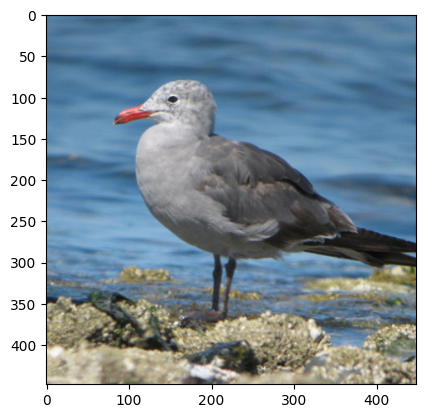

In [24]:
plt.imshow(batch_dict['pixel_values'][0].permute(1,2,0))

In [12]:
torch.argmax(outputs['class_scores'], dim=-1)

tensor([ 60, 192,  11, 167])

In [13]:
batch_dict['class_ids']

tensor([ 60, 192,  11, 167])

In [10]:
outputs['class_scores']

tensor([[11.7218, 10.7531, 15.8041,  8.4639, 10.6602,  7.4709, 10.0369,  9.4264,
          8.3152,  5.3211,  5.9040,  4.7840,  4.0994,  0.1501,  3.0656, -2.0353,
          1.3781,  1.2844, 17.8300,  1.6913,  0.7041, -1.2459, 15.0212, 15.0839,
         15.1073,  8.0090,  7.9374,  3.9356, 13.0365, 12.0342,  7.6754,  9.5370,
          8.1903,  4.9761,  0.7954,  5.8068,  5.8913,  8.3798,  7.6988,  9.4669,
          8.1669,  6.5038,  4.7216, 11.8038, 14.4293,  9.3345, -1.3795,  0.3561,
          9.1134, 10.7232,  9.5905,  4.7212, 12.0590,  0.8720, -1.9327,  9.2977,
          0.7731,  8.1475, 14.0752, 15.6602, 21.8791, 14.6193, 11.0598, 15.2304,
         12.1946, 12.4221,  9.2472,  8.0786,  4.8440,  5.9621, 14.2498, 14.2730,
          8.6882,  7.4168, -0.1531,  8.0754,  7.9991, 11.7101, 12.8377,  8.6164,
          9.8287, 12.3059,  3.3936,  8.6104,  1.1124, 11.6516,  6.7983,  0.9235,
          8.5681,  9.3820,  9.5665,  3.0148, 14.1791, 12.6639,  2.5909,  3.3263,
          5.2947,  2.6233,  

In [ ]:
max_attn_values = F.max_pool2d(outputs['attn_maps'], kernel_size=(14, 14))

In [ ]:
top_attn_values = torch.topk(max_attn_values.squeeze(), k=5, dim=-1)

In [ ]:
plt.imshow(outputs['attn_maps'][0, 10, ...].numpy())


In [ ]:
torch.max(outputs['attn_maps'][0, 10, ...])

In [ ]:
plt.imshow(outputs['attn_maps'][0, 0, ...].numpy())

In [ ]:
plt.imshow(batch_dict['pixel_values'][0].permute(1,2,0).numpy())

In [ ]:
max_attn_values.squeeze()[0]

In [ ]:
dataset_val.attr_class_map[188]

In [ ]:
dataset_val.main_df.iloc[11065]['file_path']

In [ ]:
dataset_val.attribute_df

In [ ]:
torch.topk(dataset_val.attr_class_map[187], k=5)

In [ ]:
batch_dict['class_ids']

In [ ]:
batch_dict['image_ids']

In [ ]:
batch_dict['pixel_values']

In [ ]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
normalize(batch_dict['pixel_values'])